In [ ]:

import sys
sys.path.append("/pscratch/sd/s/siennaw/scripts/pysindy")
import numpy as np 
import pandas as pd 
import pysindy as ps
import xarray as  xr  
import matplotlib.pyplot as plt

# Let's get the following time-series data 
# * chl-a 
# * kappa 
# * irrandiance




/tmp/ipykernel_1150495/4227646247.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  hydro = xr.open_dataset("/global/homes/s/siennaw/scratch/siennaw/two_species/adjoint_phytoplankton/run_hydro/HYDRO_AUGUST6-16.nc")
/tmp/ipykernel_1150495/4227646247.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data.index = pd.date_range(start='2024-08-06', periods=len(kappa), freq='10S')


Text(0.5, 1.0, 'Mean Diffusivity (Kappa) over the top 2 meters')

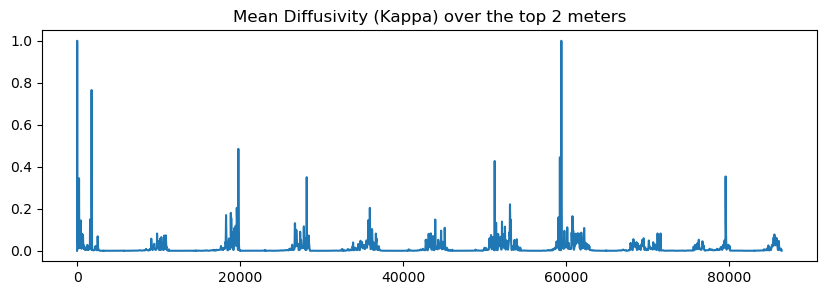

In [14]:
hydro = xr.open_dataset("/global/homes/s/siennaw/scratch/siennaw/two_species/adjoint_phytoplankton/run_hydro/HYDRO_AUGUST6-16.nc")

# Dt = 10 seconds 
hydro = hydro.sel(z=slice(2, 0))  # Select the top 2 meters
kappa = hydro.Kz.mean(dim="z").values 
kappa[kappa>1] = 1  

data = pd.DataFrame(kappa, columns=['kappa'])
data.index = pd.date_range(start='2024-08-06', periods=len(kappa), freq='10S')


fig = plt.figure(figsize=(10, 3))
plt.plot(kappa)
plt.title("Mean Diffusivity (Kappa) over the top 2 meters")

In [28]:
par = pd.read_csv("//global/homes/s/siennaw/scratch/siennaw/stockton_field_data/forcing_for_model/2024/august6-16/PAR.csv")
print(par)

data["par"] = par['Sol Rad (PAR)'].values

                      time  Sol Rad (PAR)
0      2024-08-06 00:00:00            0.0
1      2024-08-06 00:00:10            0.0
2      2024-08-06 00:00:20            0.0
3      2024-08-06 00:00:30            0.0
4      2024-08-06 00:00:40            0.0
...                    ...            ...
86396  2024-08-15 23:59:20            0.0
86397  2024-08-15 23:59:30            0.0
86398  2024-08-15 23:59:40            0.0
86399  2024-08-15 23:59:50            0.0
86400  2024-08-16 00:00:00            0.0

[86401 rows x 2 columns]


/tmp/ipykernel_1150495/3407955657.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["chla"].interpolate(method='linear', inplace=True)


Text(0.5, 1.0, 'Chlorophyll-a Concentration')

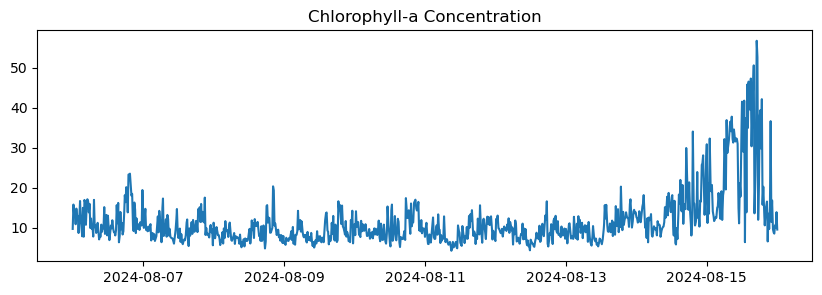

In [29]:
# Chlorophyll-a data
chla = pd.read_csv("/global/homes/s/siennaw/scratch/siennaw/stockton_field_data/chla/preece_mls.csv")
chla['time'] = pd.to_datetime(chla['DATE TIME'])
chla.dropna(subset=['VALUE'], inplace=True)

chla = pd.DataFrame(chla['VALUE'].values, columns=['chla'], index=chla['time'])

data["chla"] = chla['chla']
data["chla"].interpolate(method='linear', inplace=True)

fig = plt.figure(figsize=(10, 3))
plt.plot(data["chla"])
plt.title("Chlorophyll-a Concentration")

In [30]:
print(data)
data_mat = np.array(data)

                        kappa       chla  par
2024-08-06 00:00:00  0.000248   9.730000  0.0
2024-08-06 00:00:10  0.000877   9.797556  0.0
2024-08-06 00:00:20  0.001255   9.865111  0.0
2024-08-06 00:00:30  0.002279   9.932667  0.0
2024-08-06 00:00:40  0.004048  10.000222  0.0
...                       ...        ...  ...
2024-08-15 23:59:20  0.004512   9.762889  0.0
2024-08-15 23:59:30  0.004508   9.714667  0.0
2024-08-15 23:59:40  0.004506   9.666444  0.0
2024-08-15 23:59:50  0.004506   9.618222  0.0
2024-08-16 00:00:00  0.000000   9.570000  0.0

[86401 rows x 3 columns]


In [31]:




t = np.arange(0, len(data_mat)*10, 10)  # Time vector in seconds
print(t.shape)
print(data_mat.shape)
model = ps.SINDy(feature_names=["kappa", "chla", "par"])
model.fit(data_mat, t=t)
model.print()



(86401,)
(86401, 3)
(kappa)' = 0.000
(chla)' = 0.000
(par)' = 0.109 kappa^2


/pscratch/sd/s/siennaw/scripts/pysindy/pysindy/optimizers/stlsq.py:234: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


In [7]:

t = np.linspace(0, 1, 100)
x = 3 * np.exp(-2 * t)
y = 0.5 * np.exp(t)
X = np.stack((x, y), axis=-1)  # First column is x, second is y

In [8]:
model = ps.SINDy(feature_names=["x", "y"])
model.fit(X, t=t)
model.print()


(x)' = -2.000 x
(y)' = 1.000 y


[ 0.00000000e+00 -9.08070605e-02 -1.61208040e-01 -2.11202938e-01
 -2.40791756e-01 -2.49974492e-01 -2.38751148e-01 -2.07121722e-01
 -1.55086216e-01 -8.26446281e-02  1.02030405e-02  1.23456790e-01
  2.57116621e-01  4.11182532e-01  5.85654525e-01  7.80532599e-01
  9.95816753e-01  1.23150699e+00  1.48760331e+00  1.76410570e+00
  2.06101418e+00  2.37832874e+00  2.71604938e+00  3.07417610e+00
  3.45270891e+00  3.85164779e+00  4.27099276e+00  4.71074380e+00
  5.17090093e+00  5.65146414e+00  6.15243343e+00  6.67380880e+00
  7.21559025e+00  7.77777778e+00  8.36037139e+00  8.96337108e+00
  9.58677686e+00  1.02305887e+01  1.08948067e+01  1.15794307e+01
  1.22844608e+01  1.30098969e+01  1.37557392e+01  1.45219876e+01
  1.53086420e+01  1.61157025e+01  1.69431691e+01  1.77910417e+01
  1.86593205e+01  1.95480053e+01  2.04570962e+01  2.13865932e+01
  2.23364963e+01  2.33068054e+01  2.42975207e+01  2.53086420e+01
  2.63401694e+01  2.73921028e+01  2.84644424e+01  2.95571880e+01
  3.06703398e+01  3.18038

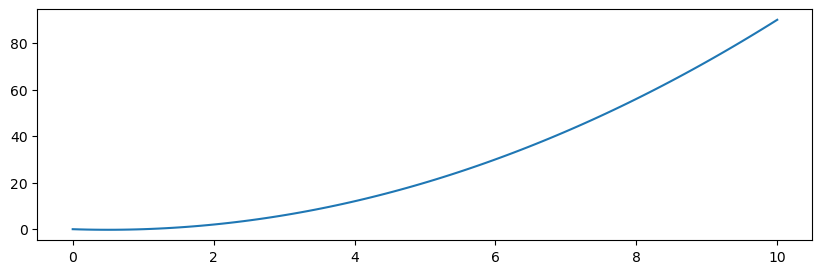

In [33]:
x = np.linspace(0, 10, 100)
eq = x**2 - x 

fig = plt.figure(figsize=(10, 3))
plt.plot(x, eq)
print(eq)